# **Setting Up the Environment** 🛠️

---


In [1]:
import sys
sys.path.append("..")  # Go up one level to access `src/`

In [2]:
import tensorflow as tf
import onnx
import tf2onnx

In [3]:
from src.inference  import FaceRecognitionInference  

In [4]:
import matplotlib.pyplot as plt

In [5]:
import cv2
import numpy as np

# 🎯 **Load our model** 🔍
---


In [7]:
# Load the trained model
model = tf.keras.models.load_model(r"..\models\best_model.h5")

# 🎯 **Generate and save ONNX and Tflite versions of our model** 🔍
---


> ONNX with embedding layer output

In [27]:
# Choose the layer before the final output for embeddings
embedding_layer = model.get_layer("dense_7").output

# Create a new model that outputs embeddings too
embedding_model = tf.keras.Model(inputs=model.input, outputs=[embedding_layer, model.output])

# Convert to ONNX
spec = (tf.TensorSpec((None, 299, 299, 3), tf.float32, name="input"),)
onnx_model, _ = tf2onnx.convert.from_keras(embedding_model, input_signature=spec, opset=13)

# Save the ONNX model
onnx_model_path = r'..\models\face_recognition_2.onnx'
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"✅ Model exported to {onnx_model_path} with embeddings included!")

✅ Model exported to ..\models\face_recognition_2.onnx with embeddings included!


In [ ]:
# # Specify input signature explicitly
# input_signature = [tf.TensorSpec(shape=[None, 299, 299, 3], dtype=tf.float32, name='input_image')]

In [ ]:
# Convert the model to ONNX format
# onnx_model,_ = tf2onnx.convert.from_keras(model)

In [ ]:
# # Save the ONNX model to file
# onnx.save_model(onnx_model, r'..\models\face_recognition.onnx')

> tflite 

In [34]:
def quantize_model(model, save_path=r"../models/face_recognition.tflite"):

    # Convert model to TFLite format with default quantization
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Apply default quantization
    tflite_model = converter.convert()

    # Save quantized model
    with open(save_path, "wb") as f:
        f.write(tflite_model)

    print(f"Quantized model saved as {save_path}")

    return save_path  # Return the quantized model for further use

In [11]:
quantized_model_path = quantize_model(model, r"../models/face_recognition.tflite")

INFO:tensorflow:Assets written to: C:\Users\ELECTR~1\AppData\Local\Temp\tmpamvyel1k\assets


INFO:tensorflow:Assets written to: C:\Users\ELECTR~1\AppData\Local\Temp\tmpamvyel1k\assets


Quantized model saved as ../models/face_recognition.tflite


> tflite with embedding layer output

In [35]:
# Choose the layer before the final output for embeddings
embedding_layer = model.get_layer("dense_7").output

# Create a new model that outputs embeddings too
embedding_model = tf.keras.Model(inputs=model.input, outputs=[embedding_layer, model.output])

In [36]:
quantized_model_path = quantize_model(embedding_model, r"../models/face_recognition_embedding.tflite")

INFO:tensorflow:Assets written to: C:\Users\ELECTR~1\AppData\Local\Temp\tmpiwzmowyp\assets


INFO:tensorflow:Assets written to: C:\Users\ELECTR~1\AppData\Local\Temp\tmpiwzmowyp\assets


Quantized model saved as ../models/face_recognition_embedding.tflite


# 🎯 **Lets test inference of all models** 🔍
---


> Models paths 

In [7]:
onnx_model_path = r'..\models\face_recognition.onnx'
tflite_model_path = r"../models/face_recognition.tflite"
keras_model_path =r"..\models\best_model.h5"

> # Initialize the FaceRecognitionInference class objects for our models :

In [8]:
# Initialize the FaceRecognitionInference class for ONNX model
onnx_inference = FaceRecognitionInference(model_path= onnx_model_path, model_type="onnx")

In [9]:
onnx_inference_similarity = FaceRecognitionInference(onnx_model_path, model_type="onnx",use_similarity=True)

In [10]:
# Initialize the FaceRecognitionInference class for TFLite model
tflite_inference = FaceRecognitionInference(tflite_model_path, model_type="tflite")

In [11]:
tflite_inference_similarity = FaceRecognitionInference(tflite_model_path, model_type="tflite",use_similarity=True)

In [12]:
# Initialize the FaceRecognitionInference class for Keras model
keras_inference = FaceRecognitionInference(keras_model_path, model_type="keras")

In [13]:
keras_inference_similarity = FaceRecognitionInference(keras_model_path, model_type="keras",use_similarity=True)

# lets test them

In [14]:
sample_img_path_1 = r"C:\Users\Electronica\Desktop\image_1.jpg"
sample_img_path_2 = r"C:\Users\Electronica\Desktop\image_2.jpg"
sample_img_path_3 = r"C:\Users\Electronica\Desktop\image_3.jpg"

In [17]:
# Test Keras model
keras_predictions, img_keras = keras_inference.detect_and_recognize(sample_img_path_3)
print("Keras Predictions:", keras_predictions)

1/1 [==============================] - 0s 53ms/step
Keras Predictions: ['pins_Tom Hardy']


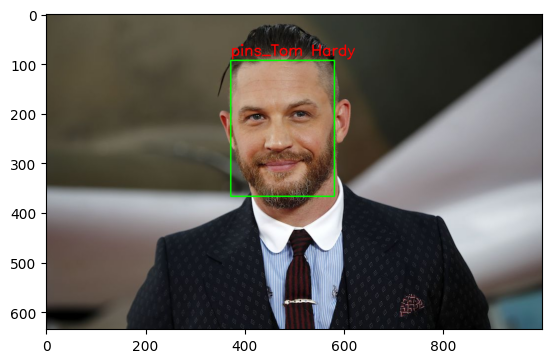

In [18]:
plt.imshow(cv2.cvtColor(img_keras, cv2.COLOR_BGR2RGB))

In [26]:
# keras_inference.model.layers[-4].name

In [23]:
keras_predictions_s, img_keras_s = keras_inference_similarity.detect_and_recognize(sample_img_path_2)
display(keras_predictions_s)

1/1 [==============================] - 0s 45ms/step


['pins_Johnny Depp (87.75%)']

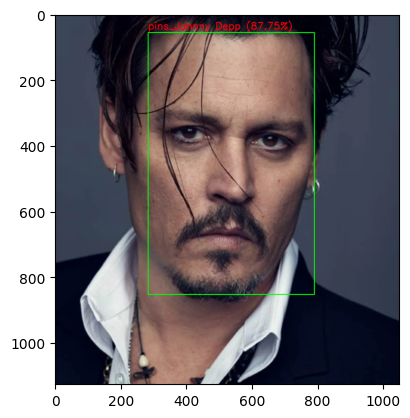

In [24]:
plt.imshow(cv2.cvtColor(img_keras_s, cv2.COLOR_BGR2RGB))

In [15]:
# Test ONNX model
onnx_predictions , onnx_img = onnx_inference.detect_and_recognize(sample_img_path_1)
print("ONNX Predictions:", onnx_predictions)

ONNX Predictions: ['pins_Johnny Depp']


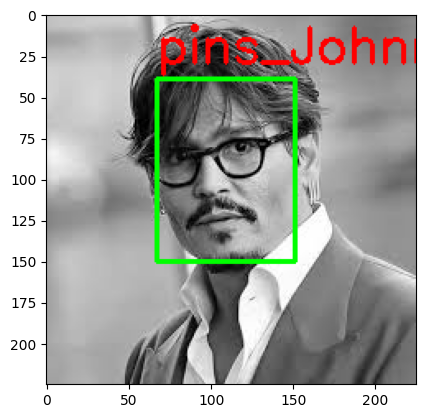

In [29]:
plt.imshow(cv2.cvtColor(onnx_img, cv2.COLOR_BGR2RGB))

In [ ]:
# onnx_inference_similarity.model.get_outputs()[1].name

'dense_8'

In [30]:
onnx_predictions_s , onnx_img_s = onnx_inference_similarity.detect_and_recognize(sample_img_path_3)
display(onnx_predictions_s)

['pins_Tom Hardy (88.24%)']

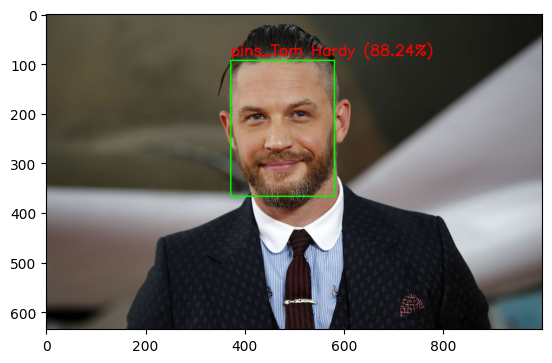

In [31]:
plt.imshow(cv2.cvtColor(onnx_img_s, cv2.COLOR_BGR2RGB))

In [32]:
# Test tflite model
tflite_predictions , tflite_img = tflite_inference.detect_and_recognize(sample_img_path_3)
print("ONNX Predictions:", tflite_predictions)

ONNX Predictions: ['pins_Tom Hardy']


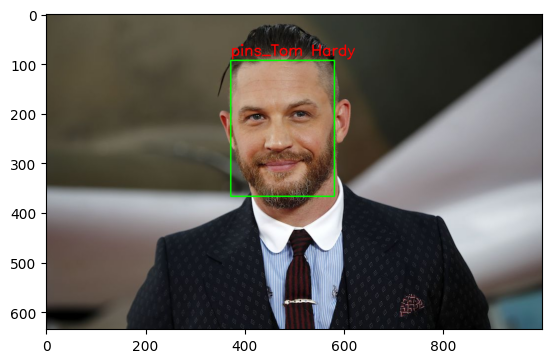

In [33]:
plt.imshow(cv2.cvtColor(tflite_img, cv2.COLOR_BGR2RGB))

In [34]:
tflite_predictions_s , tflite_img_s = tflite_inference_similarity.detect_and_recognize(sample_img_path_2)
display(tflite_predictions_s)

['pins_Johnny Depp (87.48%)']

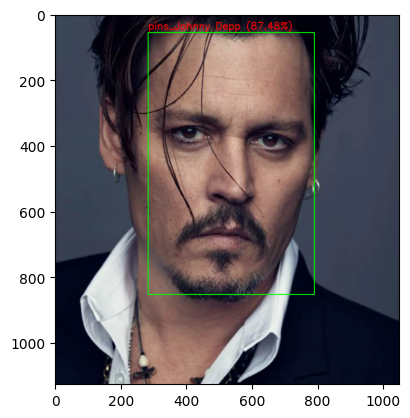

In [35]:
plt.imshow(cv2.cvtColor(tflite_img_s, cv2.COLOR_BGR2RGB))